In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

## Data Loading

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhil7280/weather-type-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'weather-type-classification' dataset.
Path to dataset files: /kaggle/input/weather-type-classification


In [3]:
!cp -r {path} /content/weather_data
!ls /content/weather_data


weather_classification_data.csv  weather-type-classification


In [30]:
data = pd.read_csv("/content/weather_data/weather_classification_data.csv")

##Data Preprocessing

In [31]:
data.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [32]:
data.isnull().sum()

,0
Temperature,0
Humidity,0
Wind Speed,0
Precipitation (%),0
Cloud Cover,0
Atmospheric Pressure,0
UV Index,0
Season,0
Visibility (km),0
Location,0


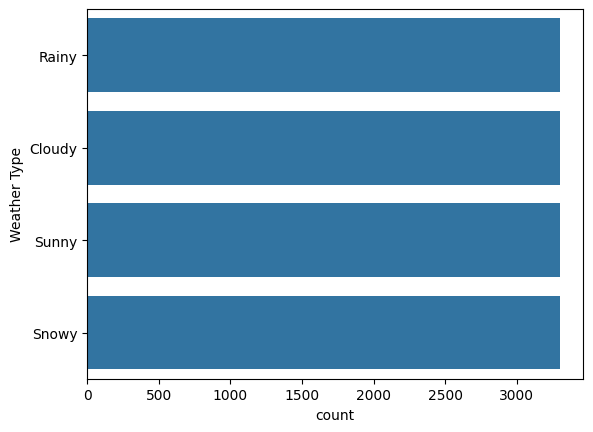

In [33]:
# plot the weather type to check the balancing of the data
from matplotlib import pyplot as plt
import seaborn as sns

sns.countplot(data['Weather Type'])
plt.show()

In [34]:
data['Cloud Cover'].unique()

array(['partly cloudy', 'clear', 'overcast', 'cloudy'], dtype=object)

In [35]:
data['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

In [39]:
data['Location'].unique()

array(['inland', 'mountain', 'coastal'], dtype=object)

In [36]:
#  one-hot encoding
cloud_dummies = pd.get_dummies(data['Cloud Cover'], prefix='Cloud_Cover')
location_dummies = pd.get_dummies(data['Location'], prefix='Location')
season_dummies = pd.get_dummies(data['Season'], prefix='Season')

data_encoded = pd.concat([
    data.drop(['Cloud Cover', 'Location', 'Season'], axis=1),
    cloud_dummies,
    location_dummies,
    season_dummies
], axis=1)

In [38]:
data_encoded.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Weather Type,Cloud_Cover_clear,Cloud_Cover_cloudy,Cloud_Cover_overcast,Cloud_Cover_partly cloudy,Location_coastal,Location_inland,Location_mountain,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,14.0,73,9.5,82.0,1010.82,2,3.5,Rainy,False,False,False,True,False,True,False,False,False,False,True
1,39.0,96,8.5,71.0,1011.43,7,10.0,Cloudy,False,False,False,True,False,True,False,False,True,False,False
2,30.0,64,7.0,16.0,1018.72,5,5.5,Sunny,True,False,False,False,False,False,True,False,True,False,False
3,38.0,83,1.5,82.0,1026.25,7,1.0,Sunny,True,False,False,False,True,False,False,False,True,False,False
4,27.0,74,17.0,66.0,990.67,1,2.5,Rainy,False,False,True,False,False,False,True,False,False,False,True


In [40]:
x = data_encoded.drop('Weather Type', axis=1)
y = data_encoded['Weather Type']

feature_names = x.columns.tolist()   # <- here!

In [43]:
#label encoding for y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [44]:
#Standard Scaling for x values
scaler = StandardScaler()
x = scaler.fit_transform(x)

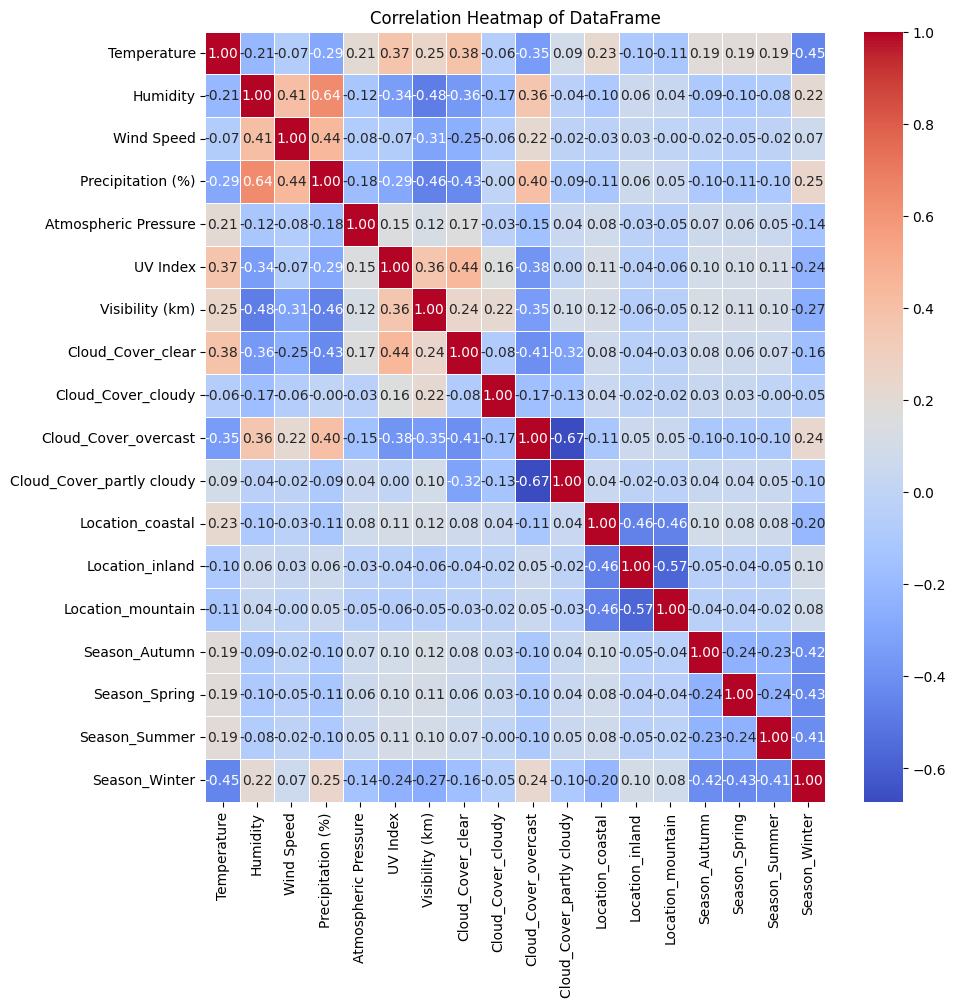

In [42]:
#checking input coloumns corelation
correlation_matrix = x.corr()
plt.figure(figsize=(10, 10)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame')
plt.show()


## Data Splitting

In [87]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42
)

## ML Model Training & Eval

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
rf = RandomForestClassifier()

In [92]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [93]:
y_pred = rf.predict(x_val)

In [94]:
print(classification_report(y_pred, y_val, digits=4))


              precision    recall  f1-score   support

           0     0.8986    0.8680    0.8830       674
           1     0.9119    0.9021    0.9070       654
           2     0.9401    0.9334    0.9367       706
           3     0.8924    0.9439    0.9174       606

    accuracy                         0.9114      2640
   macro avg     0.9107    0.9119    0.9110      2640
weighted avg     0.9116    0.9114    0.9112      2640



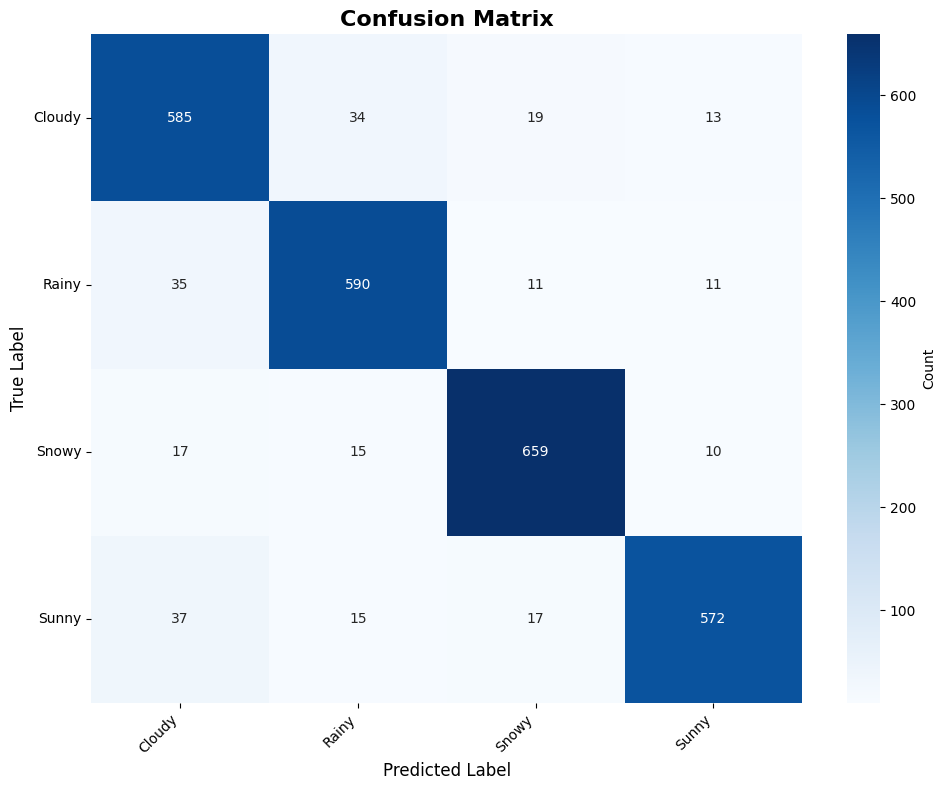

In [95]:
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

to find the best parameter we try GridSearchCV

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [96]:
rf_param_grid = {
    'n_estimators': [50,100,150],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}


Training Random Forest with Grid Search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters for Random Forest:
{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 150}

Best Cross-Validation Score: 0.9156

Validation Accuracy: 0.9136

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.89       651
       Rainy       0.90      0.90      0.90       647
       Snowy       0.93      0.94      0.94       701
       Sunny       0.95      0.90      0.93       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



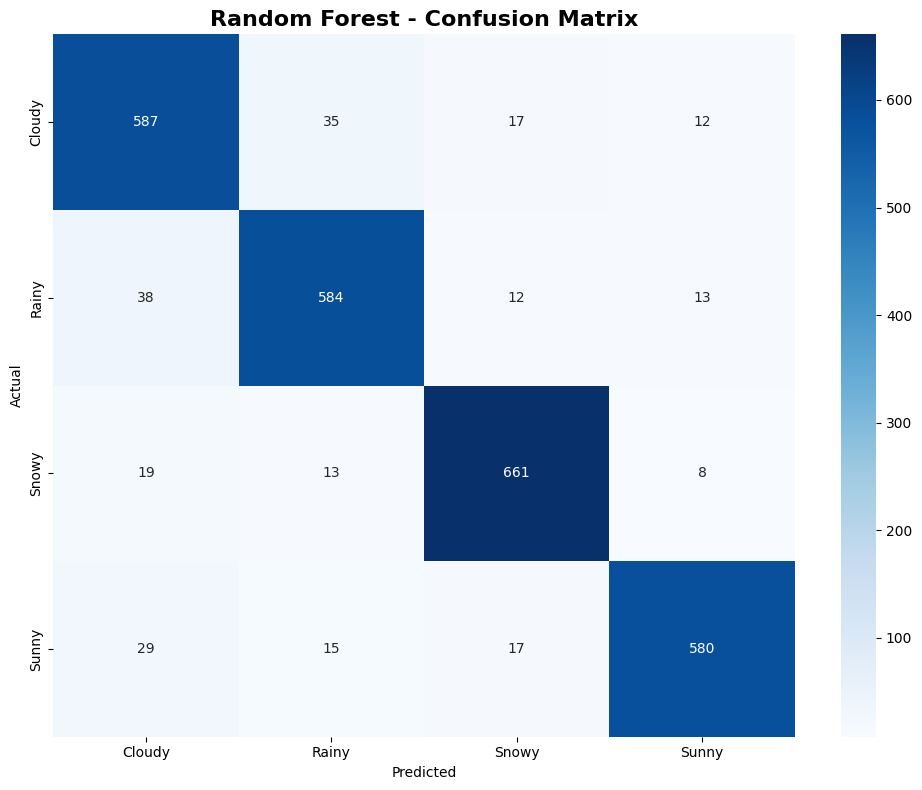

In [101]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search with Cross-Validation
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit the model
print("\nTraining Random Forest with Grid Search...")
rf_grid.fit(x_train, y_train)

# Best parameters
print("\nBest Parameters for Random Forest:")
print(rf_grid.best_params_)
print(f"\nBest Cross-Validation Score: {rf_grid.best_score_:.4f}")

# Predictions
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(x_val)

# Evaluate
print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf, target_names=label_encoder.classes_))

# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest - Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## DL Model Training & Eval

In [49]:
X_train = torch.tensor(x_train.toarray() if hasattr(x_train, "toarray") else x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val   = torch.tensor(x_val.toarray() if hasattr(x_val, "toarray") else x_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.long)

In [50]:
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [66]:
class WeatherNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256)
        self.ln1 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.fc3 = nn.Linear(128, 64)
        self.ln3 = nn.LayerNorm(64)
        self.fc4 = nn.Linear(64, out_dim)

    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        return self.fc4(x)

In [67]:
model = WeatherNN(X_train.shape[1], len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

WeatherNN(
  (fc1): Linear(in_features=18, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
)

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [74]:
epochs = 100
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        Xv, yv = X_val.to(device), y_val.to(device)
        logits_val = model(Xv)
        val_loss = criterion(logits_val, yv).item()
        preds = torch.argmax(logits_val, dim=1)
        val_acc = (preds == yv).float().mean().item()

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f}")


Epoch 01 | train_loss 0.0169 | val_loss 0.4790 | val_acc 0.9023
Epoch 02 | train_loss 0.0167 | val_loss 0.4793 | val_acc 0.9023
Epoch 03 | train_loss 0.0166 | val_loss 0.4796 | val_acc 0.9027
Epoch 04 | train_loss 0.0165 | val_loss 0.4799 | val_acc 0.9027
Epoch 05 | train_loss 0.0164 | val_loss 0.4801 | val_acc 0.9027
Epoch 06 | train_loss 0.0163 | val_loss 0.4806 | val_acc 0.9034
Epoch 07 | train_loss 0.0162 | val_loss 0.4808 | val_acc 0.9030
Epoch 08 | train_loss 0.0161 | val_loss 0.4811 | val_acc 0.9030
Epoch 09 | train_loss 0.0161 | val_loss 0.4813 | val_acc 0.9030
Epoch 10 | train_loss 0.0160 | val_loss 0.4816 | val_acc 0.9034
Epoch 11 | train_loss 0.0159 | val_loss 0.4818 | val_acc 0.9030
Epoch 12 | train_loss 0.0158 | val_loss 0.4820 | val_acc 0.9030
Epoch 13 | train_loss 0.0157 | val_loss 0.4823 | val_acc 0.9030
Epoch 14 | train_loss 0.0157 | val_loss 0.4826 | val_acc 0.9030
Epoch 15 | train_loss 0.0156 | val_loss 0.4828 | val_acc 0.9030
Epoch 16 | train_loss 0.0155 | val_loss 


Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.87      0.88      0.88       651
       Rainy       0.88      0.89      0.89       647
       Snowy       0.94      0.94      0.94       701
       Sunny       0.92      0.90      0.91       641

    accuracy                           0.90      2640
   macro avg       0.90      0.90      0.90      2640
weighted avg       0.90      0.90      0.90      2640



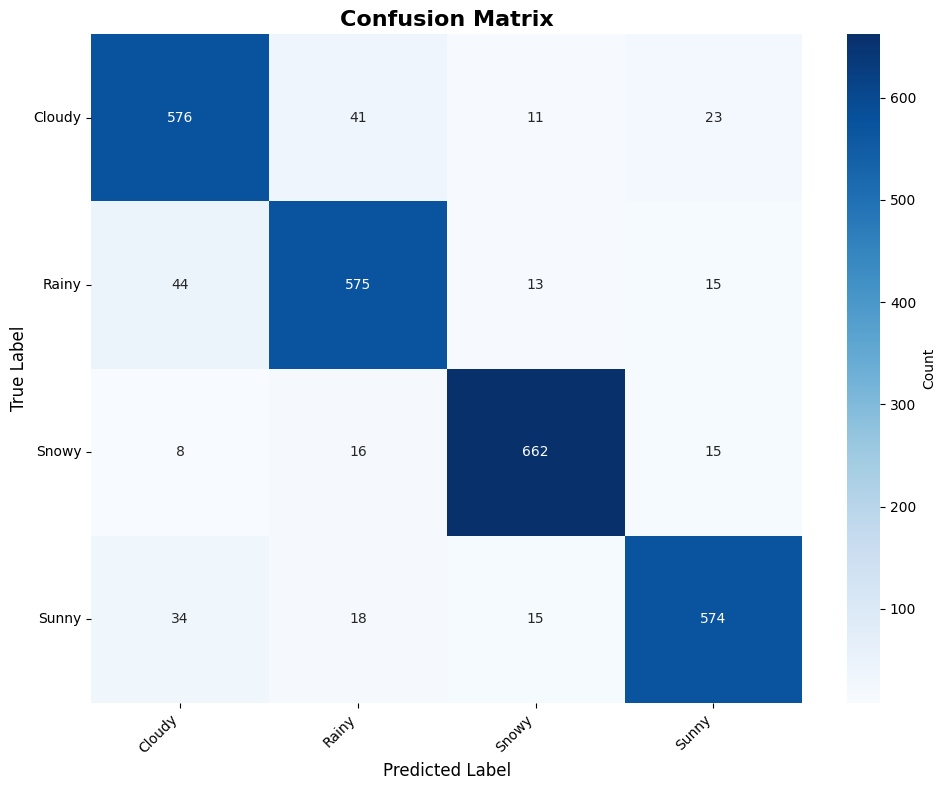

In [75]:
# 8. Final evaluation
print("\nClassification Report:")
print(classification_report(y_val.numpy(), preds.cpu().numpy(), target_names=label_encoder.classes_))

# Create confusion matrix
cm = confusion_matrix(y_val.numpy(), preds.cpu().numpy())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
1